# Vision Transformer

<img src='https://miro.medium.com/v2/resize:fit:930/1*XdXMpFcgQCYBSDRvk-hh_w.jpeg'/>

## Student information

- **Full name:** Trần Nguyên Huân
- **Id:** 21127050

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
import transformers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Implement Attention module

In [33]:
class Attention(nn.Module):
    def __init__(self, heads, embed_dim, dropout=0.1, fast_attention=False, qkv_bias=False):
        """
        Initializes the Attention module.

        Args:
            heads (int): Number of attention heads.
            embed_dim (int): Dimension of the embedding.
            dropout (float): Dropout rate.
            fast_attention (bool): Flag for fast attention (not used in this implementation).
            qkv_bias (bool): Whether to use bias in the QKV linear layer.
        """
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // heads
        self.scale = self.head_dim ** -0.5  # Scaling factor for attention scores
        
        self.fast_attention = fast_attention
        self.qkv_bias = qkv_bias

        # Linear layer to generate Q, K, V matrices
        self.W = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        # Linear layer for the output
        self.fc_out = nn.Linear(embed_dim, embed_dim)
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        """
        Forward pass through the Attention module.

        Args:
            inp (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, embed_dim).
        """
        batch_size, seq_len, embed_dim = inp.size()

        # Generate Q, K, V matrices by splitting the output of the linear layer
        QKV = self.W(inp).chunk(3, dim=-1)
        Q, K, V = QKV[0], QKV[1], QKV[2]

        # Reshape and transpose Q, K, V for multi-head attention
        Q = Q.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.heads, self.head_dim).transpose(1, 2)

        # Calculate attention scores
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        # Apply softmax to get attention probabilities
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        # Apply dropout to attention probabilities
        attention_probs = self.dropout(attention_probs)

        # Calculate the weighted sum of values
        attention = torch.matmul(attention_probs, V)
        # Reshape and transpose the attention output back to the original shape
        attention = attention.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dim)
        # Pass through the final linear layer
        out = self.fc_out(attention)
        return out

## Implement TransformerBlock module

In [34]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, heads, dropout=0.1, fast_attention=False, qkv_bias=False):
        """
        Initializes the Transformer Block.

        Args:
            embed_dim (int): Dimension of the embedding.
            mlp_dim (int): Dimension of the MLP (Feed Forward Network).
            heads (int): Number of attention heads.
            dropout (float): Dropout rate.
            fast_attention (bool): Flag for fast attention (not used in this implementation).
            qkv_bias (bool): Whether to use bias in the QKV linear layer.
        """
        super(TransformerBlock, self).__init__()
        # Attention layer
        self.attention = Attention(heads, embed_dim, dropout, fast_attention, qkv_bias)
        # First linear layer in the feed forward network
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        # Second linear layer in the feed forward network
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        # GELU activation function
        self.activation = nn.GELU()
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inp):
        """
        Forward pass through the Transformer Block.

        Args:
            inp (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        # Apply layer normalization and attention
        attn_out = self.attention(self.norm1(inp))
        # Add residual connection and apply dropout
        inp = inp + self.dropout1(attn_out)
        
        # Apply layer normalization, feed forward network, activation, and dropout
        ff_out = self.activation(self.fc1(self.norm2(inp)))
        ff_out = self.fc2(self.dropout2(ff_out))
        # Add residual connection and apply dropout
        inp = inp + self.dropout2(ff_out)
        
        return inp

## Implement Transformer module

In [35]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, mlp_dim, layers, heads=8, dropout=0.1, fast_attention=False, qkv_bias=False):
        """
        Initializes the Transformer model.

        Args:
            embed_dim (int): Dimension of the embedding.
            mlp_dim (int): Dimension of the MLP (Feed Forward Network).
            layers (int): Number of Transformer blocks.
            heads (int): Number of attention heads.
            dropout (float): Dropout rate.
            fast_attention (bool): Flag for fast attention (not used in this implementation).
            qkv_bias (bool): Whether to use bias in the QKV linear layer.
        """
        super(Transformer, self).__init__()
        # Create a list of Transformer blocks
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, mlp_dim, heads, dropout, fast_attention, qkv_bias) for _ in range(layers)]
        )

    def forward(self, inp):
        """
        Forward pass through the Transformer model.

        Args:
            inp (torch.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            tuple: Final output tensor and list of attention maps.
        """
        attentions = []  # List to store attention maps
        for block in self.trans_blocks:
            inp = block(inp)  # Pass input through each Transformer block
            attentions.append(inp)  # Collect attention maps (if modified to return)
        return inp, attentions  # Return both final output and attention maps

## Implement ClassificationHead module

In [36]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, classes, dropout=0.1):
        """
        Initializes the Classification Head.

        Args:
            embed_dim (int): Dimension of the embedding.
            classes (int): Number of output classes.
            dropout (float): Dropout rate.
        """
        super(ClassificationHead, self).__init__()
        # First linear layer reduces the embedding dimension by half
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        # GELU activation function
        self.activation = nn.GELU()
        # Second linear layer maps to the number of classes
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        """
        Forward pass through the Classification Head.

        Args:
            inp (torch.Tensor): Input tensor of shape (batch_size, embed_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, classes).
        """
        # Apply dropout, first linear layer, and activation function
        x = self.dropout(self.activation(self.fc1(inp)))
        # Apply second linear layer to get class scores
        x = self.fc2(x)
        return x

## Implement VisionTransformer module

In [37]:
class VisionTransformer(nn.Module):
    def __init__(self, inp_channels, patch_size, max_len, heads, classes, layers, embed_dim, mlp_dim, dropout=0.1, fast_attention=False, qkv_bias=False):
        """
        Initializes the Vision Transformer model.

        Args:
            inp_channels (int): Number of input channels (e.g., 3 for RGB images).
            patch_size (int): Size of each image patch.
            max_len (int): Maximum length of the sequence (number of patches).
            heads (int): Number of attention heads.
            classes (int): Number of output classes.
            layers (int): Number of Transformer blocks.
            embed_dim (int): Dimension of the embedding.
            mlp_dim (int): Dimension of the MLP (Feed Forward Network).
            dropout (float): Dropout rate.
            fast_attention (bool): Flag for fast attention (not used in this implementation).
            qkv_bias (bool): Whether to use bias in the QKV linear layer.
        """
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        # Positional embedding for patches and class token
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len + 1, embed_dim))
        # Class token to be appended to the patch embeddings
        self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Linear layer to convert patches to embeddings
        self.patch_to_embedding = nn.Linear(inp_channels * patch_size * patch_size, embed_dim)
        # Transformer model
        self.transformer = Transformer(embed_dim, mlp_dim, layers, heads, dropout, fast_attention, qkv_bias)
        # Classification head
        self.classification_head = ClassificationHead(embed_dim, classes, dropout)

    def forward(self, inp):
        """
        Forward pass through the Vision Transformer model.

        Args:
            inp (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            tuple: Class scores and attention maps.
        """
        batch_size, channels, height, width = inp.size()
        # Calculate the number of patches
        num_patches = (height // self.patch_size) * (width // self.patch_size)
        # Extract patches from the input image
        patches = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # Rearrange patches and flatten them
        patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, num_patches, -1)
        # Convert patches to embeddings
        patches = self.patch_to_embedding(patches)
        
        # Expand class token to the batch size and concatenate with patch embeddings
        class_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_tokens, patches), dim=1)
        # Add positional embeddings
        x += self.pos_embedding[:, :x.size(1)]
        
        # Pass through the Transformer
        x, attention_maps = self.transformer(x)
        # Use the classification head on the class token output
        class_out = self.classification_head(x[:, 0])
        
        return class_out, attention_maps

## Define CIFAR10 dataset

In [38]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Initializes the Custom CIFAR-10 Dataset.

        Args:
            dataset (Dataset): The original CIFAR-10 dataset.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: Transformed image and its corresponding label.
        """
        img, label = self.dataset[idx]
        if self.transform:
            # Apply the transformation to the image
            img = self.transform(image=img)['image']
        return img, label

## Define Config module for VIT

In [14]:
class Config:
    image_height = 32
    image_width = 32
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    Batch_Size = 1024
    Model_Path = 'best_vit_model3.pth'
    LR = 4e-4
    Epochs = 1
    weight_decay = 0.1

## Define Training and Evaluation functions

In [9]:
def train_fn(model, train_loader, optimizer, scheduler, device):
    """
    Trains the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        device (torch.device): Device to run the training on (CPU or GPU).

    Returns:
        tuple: Training accuracy and average loss for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Unpack the logits if outputs is a tuple

        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return accuracy, avg_loss

def eval_fn(model, val_loader, device):
    """
    Evaluates the model on the validation data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for the validation data.
        device (torch.device): Device to run the evaluation on (CPU or GPU).

    Returns:
        tuple: Validation accuracy and average loss.
    """
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Unpack the logits if outputs is a tuple
            loss = F.cross_entropy(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    accuracy = correct_preds / total_preds
    return accuracy, avg_loss

def train_and_evaluate(model, train_loader, val_loader, config):
    """
    Trains and evaluates the model.

    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        config (object): Configuration object containing training parameters.

    Returns:
        None
    """
    if torch.cuda.is_available():
        accelerator = 'cuda'
    else:
        accelerator = 'cpu'
    
    device = torch.device(accelerator)
    print(f'Using {device} for training')
    torch.backends.cudnn.benchmark = True

    model = model.to(device)

    optimizer = transformers.AdamW(model.parameters(), lr=config.LR, weight_decay=config.weight_decay)

    num_training_steps = int((config.Epochs * len(train_loader.dataset)) / config.Batch_Size)

    scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps
    )

    best_acc = 0
    best_model = None

    # For plotting
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(config.Epochs):
        train_acc, train_loss = train_fn(model, train_loader, optimizer, scheduler, device)
        val_acc, val_loss = eval_fn(model, val_loader, device)
        
        print(f'\nEPOCH     =  {epoch+1} / {config.Epochs} | LR =  {scheduler.get_last_lr()[0]}')
        print(f'TRAIN ACC = {train_acc*100:.2f}% | TRAIN LOSS = {train_loss:.4f}')
        print(f'VAL ACC   = {val_acc*100:.2f}% | VAL LOSS = {val_loss:.4f}')
        
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()

    torch.save(best_model, config.Model_Path)
    print(f'Best model saved to {config.Model_Path}')

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, config.Epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, config.Epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot3.png')
    plt.close()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, config.Epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.Epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot3.png')
    plt.close()

    print('Plots saved as accuracy_plot.png and loss_plot.png')

## Define function RUN Program

In [10]:
def run():
    batch_size = 512
    num_epochs = 60   
    learning_rate = 3e-4  
    num_classes = 10
    patch_size = 16 
    max_len = 512 
    embed_dim = 768
    mlp_dim = 3072
    layers = 12 
    heads = 12
    dropout = 0.4
    channels = 3


    model = VisionTransformer(
        inp_channels=channels, 
        patch_size=patch_size, 
        max_len=(224 // patch_size) ** 2, 
        heads=heads, 
        classes=num_classes, 
        layers=layers, 
        embed_dim=embed_dim, 
        mlp_dim=mlp_dim, 
        dropout=dropout,
        fast_attention=True,
        qkv_bias=True
    ).cuda()

    
    config = Config()

    train_transform = transforms.Compose([
        transforms.Resize((config.image_height, config.image_width)),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0, hue=0),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=config.mean, std=config.std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((config.image_height, config.image_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=config.mean, std=config.std)
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transforms)

    # Apply transformations
    # train_data = CustomCIFAR10Dataset(train_dataset, transform=train_transform)
    # val_data = CustomCIFAR10Dataset(val_dataset, transform=val_transforms)

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.Batch_Size,
        num_workers=4,
        pin_memory=True,
        shuffle=True,
        
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.Batch_Size,
        num_workers=4,
        pin_memory=True,
        shuffle=False
    )
    
    train_and_evaluate(model, train_loader, val_loader, config)

In [11]:
if __name__ == '__main__':
    run()

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using cuda for training


Training:   0%|          | 0/49 [00:00<?, ?it/s]

## Validate model

In [12]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [16]:
transforms_test = transforms.Compose([
	transforms.Resize((Config.image_height, Config.image_width)),
	transforms.ToTensor(),
	transforms.Normalize(mean=Config.mean, std=Config.std)
])

dataset_test  = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transforms_test)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=100, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
	       'dog', 'frog', 'horse', 'ship', 'truck')

images, labels = next(iter(test_loader))
_, num_ch, size, _ = images.shape

Files already downloaded and verified


- batch_size = 1024
- num_epochs = 60   
- learning_rate = 3e-4  
- num_classes = 10
- patch_size = 16 
- max_len = 512 
- embed_dim = 384
- mlp_dim = 1536
- layers = 12 
- heads = 6
- dropout = 0.4  
- channels = 3

In [43]:
batch_size = 1024
num_epochs = 60   
learning_rate = 3e-4  
num_classes = 10
patch_size = 16 
max_len = 512 
embed_dim = 384
mlp_dim = 1536
layers = 12 
heads = 6
dropout = 0.4  
channels = 3


model = VisionTransformer(
    inp_channels=channels, 
    patch_size=patch_size, 
    max_len=(224 // patch_size) ** 2, 
    heads=heads, 
    classes=num_classes, 
    layers=layers, 
    embed_dim=embed_dim, 
    mlp_dim=mlp_dim, 
    dropout=dropout,
    fast_attention=True,
    qkv_bias=True
).cuda()

model.load_state_dict(torch.load('best_vit_model1.pth'))
model.eval()

VisionTransformer(
  (patch_to_embedding): Linear(in_features=768, out_features=384, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention): Attention(
          (W): Linear(in_features=384, out_features=1152, bias=True)
          (fc_out): Linear(in_features=384, out_features=384, bias=True)
          (dropout): Dropout(p=0.4, inplace=False)
        )
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classification_head): ClassificationHead(
    (fc1): Linear(in_features=384, out_features=192, bias=True)
    (activation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


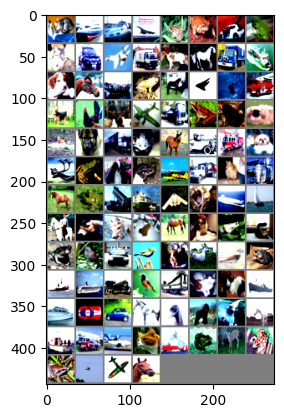

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse
Predicted:  dog   ship  ship  plane deer  frog  car   horse dog   ship  plane truck cat   car   truck bird  dog   dog   ship  frog  horse plane ship  car   horse frog  horse truck car   bird  frog  bird  bird  horse truck dog   frog  truck truck plane ship  frog  truck deer  plane truck frog  ship  bird  deer  ship  ship  frog  frog  ship  ship  dog   cat   horse horse deer  deer  ho

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images, labels = next(iter(test_loader))

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[j]:5s}' for j in labels))

with torch.no_grad():
  outputs = model(images.to(device))
_, predicted = torch.max(outputs[0], 1)
acc = ((predicted == labels.cuda()) * 1.).mean() * 100

print('Predicted: ', ' '.join(f'{classes[j]:5s}'
                              for j in predicted))
print(f'\nAccuracy is {acc}%')

- num_classes = 10
- patch_size = 16
- max_len = 512 
- embed_dim = 192 
- mlp_dim = 768  
- layers = 12 
- heads = 3 
- dropout = 0.2  
- channels = 3

In [40]:
num_classes = 10
patch_size = 16
max_len = 512 
embed_dim = 192 
mlp_dim = 768  
layers = 12 
heads = 3 
dropout = 0.2  
channels = 3


model = VisionTransformer(
    inp_channels=channels, 
    patch_size=patch_size, 
    max_len=(224 // patch_size) ** 2, 
    heads=heads, 
    classes=num_classes, 
    layers=layers, 
    embed_dim=embed_dim, 
    mlp_dim=mlp_dim, 
    dropout=dropout,
    fast_attention=True,
    qkv_bias=True
).cuda()

model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

VisionTransformer(
  (patch_to_embedding): Linear(in_features=768, out_features=192, bias=True)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention): Attention(
          (W): Linear(in_features=192, out_features=576, bias=True)
          (fc_out): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (classification_head): ClassificationHead(
    (fc1): Linear(in_features=192, out_features=96, bias=True)
    (activation): GE

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
  outputs = model(images.to(device))
_, predicted = torch.max(outputs[0], 1)
acc = ((predicted == labels.cuda()) * 1.).mean() * 100

print('Predicted: ', ' '.join(f'{classes[j]:5s}'
                              for j in predicted))
print(f'\nAccuracy is {acc}%')

Predicted:  cat   ship  ship  plane deer  frog  car   frog  dog   car   plane truck dog   horse truck ship  cat   horse ship  frog  car   bird  bird  truck dog   bird  frog  plane truck frog  frog  deer  horse dog   truck car   frog  truck truck dog   deer  frog  dog   bird  plane truck cat   ship  horse frog  truck ship  frog  cat   ship  ship  dog   ship  dog   dog   horse cat   frog  truck frog  bird  car   bird  cat   plane deer  horse ship  ship  plane deer  truck cat   cat   ship  ship  car   car   cat   bird  horse bird  bird  ship  truck plane dog   ship  frog  deer  deer  frog  plane plane horse

Accuracy is 71.0%


### Evaluation by Using Confusion Matrix 

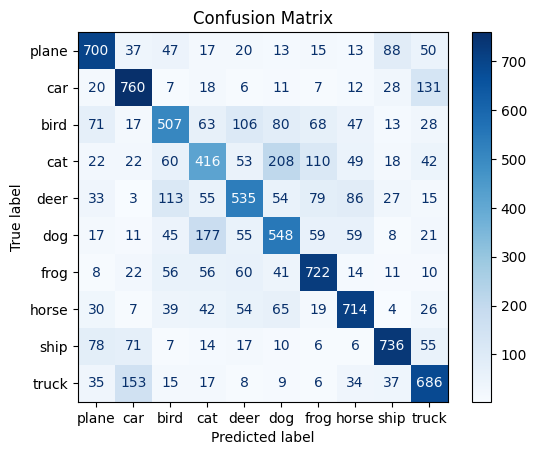

In [45]:
# Function to get predictions and true labels
def get_predictions_and_labels(model, dataloader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Extract logits if outputs is a tuple
            else:
                logits = outputs
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

-- THE END --